**O objetivo deste notebook é demonstrar como calcular os testes *t* de Student e de Welch usando algumas bibliotecas do Python. Medidas de tamanho de efeito também são reportadas.**

**Autor: Marcos Lima**

In [1]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ttest_ind.html#statsmodels.stats.weightstats.ttest_ind

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.weightstats import ttest_ind

Antes de mais nada, criaremos uma função que calcula diferentes medidas de tamanho de efeito. As fórmulas são baseadas em **Lakens, D. (2013). Calculating and reporting effect sizes to facilitate cumulative science: A practical primer for t-tests and ANOVAs. *Frontiers in Psychology*, *4*, eArticle 863. https://doi.org/10.3389/fpsyg.2013.00863**

In [2]:
# Criando uma função que retorna tamanhos de efeito (d de Cohen, g de Hedges, delta de Glass, etc.)
def tamanho_de_efeito(x, y, independent = True):
  '''
  Recebe dois vetores de escores e calcula tamanhos de efeito para delineamentos independentes
  ou de medidas repetidas.
  '''

  # teste t independente
  if independent:
    # Equação 1 de Lakens (2013), d de Cohen para delineamento independente
    numerador = np.mean(x) - np.mean(y)
    denominador = ((np.std(x, ddof = 1) ** 2 * (x.size - 1) + np.std(y, ddof = 1) ** 2 * (y.size - 1)) / (x.size + y.size - 2)) ** 0.5
    d = numerador / denominador
    
    # Equação 4 de Lakens (2013), g de Hedges para delineamento independente
    J = 1 - (3 / (4 * (x.size + y.size) - 9))
    g = d * J

    # delta de Glass
    delta = (np.mean(x) - np.mean(y)) / np.std(x, ddof = 1)
    
    # Retorna as variáveis criadas
    return d, g, delta

  # teste t pareado
  else:
    # Equação 9 de Lakens (2013), d de Cohen para medidas repetidas   
    corr = np.corrcoef(x, y)[0][1]
    numerador = np.mean(x - y)
    denominador = (np.std(x, ddof = 1) ** 2 + np.std(y, ddof = 1) ** 2 - 2 * corr * np.std(x, ddof = 1) * np.std(y, ddof = 1)) ** 0.5 * (2 * (1 - corr)) ** 0.5
    d_rm = numerador / denominador

    # Equação 10 de Lakens (2013), d de Cohen para medidas repetidas com média dos DPs
    numerador = np.mean(x - y)
    denominador = (np.std(x, ddof = 1) + np.std(y, ddof = 1)) / 2
    d_av = numerador / denominador

    return d_rm, d_av

## **Teste *t* de Student**

In [7]:
# Dados de Lakens (2013), adaptados por mim
# A avaliação dos participantes aos filmes Titanic e The Green Mile diferem entre si?
titanic = np.array([9, 7, 8, 9, 8, 9, 9, 10, 9, 9])
the_green_mile = np.array([9, 6, 7, 8, 7, 9, 8, 8, 8, 7])

# Calculando índices de tamanho de efeito
d, g, delta = tamanho_de_efeito(titanic, the_green_mile, independent = True)

# Rodando o teste t de Student
t, p, gl = ttest_ind(titanic, the_green_mile, alternative = 'two-sided', usevar = 'pooled')

# Imprimindo os resultados
# ddof = 1 na função np.std() tem como objetivo usar N - 1 no denominador do DP
print(f'''O grupo que assistiu Titanic avaliou o filme como significativamente mais agradável (M = {np.mean(titanic):.2f},
DP = {np.std(titanic, ddof = 1):.2f}) do que o grupo que avaliou o filme The Green Mile (M = {np.mean(the_green_mile):.2f},
DP = {np.std(the_green_mile, ddof = 1):.2f}), t({gl:.0f}) = {t:.2f}, p = {p:.2f}, delta = {delta:.2f}, d = {d:.2f}, g = {g:.2f}.''')


O grupo que assistiu Titanic avaliou o filme como significativamente mais agradável (M = 8.70,
DP = 0.82) do que o grupo que avaliou o filme The Green Mile (M = 7.70,
DP = 0.95), t(18) = 2.52, p = 0.02, delta = 1.21, d = 1.13, g = 1.08.


## **Teste *t* de Welch**

In [8]:
# Dados de Lakens (2013), adaptado por mim
# A avaliação dos participantes aos filmes Titanic e The Green Mile diferem entre si?

# Rodando o teste t de Welch
t, p, gl = ttest_ind(titanic, the_green_mile, alternative = 'two-sided', usevar = 'unequal')

# Imprimindo os resultados
# ddof = 1 na função np.std() tem como objetivo usar N - 1 no denominador do DP
print(f'''O grupo que assistiu Titanic avaliou o filme como significativamente mais agradável (M = {np.mean(titanic):.2f},
DP = {np.std(titanic, ddof = 1):.2f}) do que o grupo que avaliou o filme The Green Mile (M = {np.mean(the_green_mile):.2f},
DP = {np.std(the_green_mile, ddof = 1):.2f}), t({gl:.2f}) = {t:.2f}, p = {p:.2f}, delta = {delta:.2f}, d = {d:.2f}, g = {g:.2f}.''')

O grupo que assistiu Titanic avaliou o filme como significativamente mais agradável (M = 8.70,
DP = 0.82) do que o grupo que avaliou o filme The Green Mile (M = 7.70,
DP = 0.95), t(17.65) = 2.52, p = 0.02, delta = 1.21, d = 1.13, g = 1.08.


## **Teste *t* pareado**

In [5]:
# Aqui, assumimos que os dados dos vetores titanic e the_green_mile são oriundos dos mesmos participantes
# (i.e., cada participante assistiu aos dois filmes, emitindo avaliações para cada um desses filmes)

from scipy import stats

# Calculando os tamanhos de efeito
d_rm, d_av = tamanho_de_efeito(titanic, the_green_mile, independent = False)

# Calculando graus de liberdade, pois função a seguir não retorna seu valor
# graus de liberdade = número de pares - 1
gl = titanic.size - 1

# Calculando o teste t pareado
t, p = stats.ttest_rel(titanic, the_green_mile)

# Imprimindo os resultados
# ddof = 1 na função np.std() tem como objetivo usar N - 1 no denominador do DP
print(f'''A avaliação dos participantes ao filme Titanic foi significativamente mais agradável (M = {np.mean(titanic):.2f},
DP = {np.std(titanic, ddof = 1):.2f}) do que a avaliação ao filme The Green Mile (M = {np.mean(the_green_mile):.2f},
DP = {np.std(the_green_mile, ddof = 1):.2f}), t({gl:.0f}) = {t:.2f}, p = {p:.3f}, d_rm = {d_rm:.2f}, d_av = {d_av:.2f}.''')

A avaliação dos participantes ao filme Titanic foi significativamente mais agradável (M = 8.70,
DP = 0.82) do que a avaliação ao filme The Green Mile (M = 7.70,
DP = 0.95), t(9) = 4.74, p = 0.001, d_rm = 2.02, d_av = 1.13.


### Gerando um gráfico que ilustra os resultados acima. Para fins de simplificação, usaremos erros padrões das médias como barras de erro. 

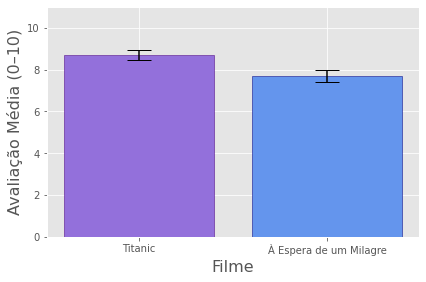

In [6]:
# Gráfico de barras com pontos individuais
w = 0.8    # largura da barra
x = [1, 2] # coordenadas das barras no eixo x

# Nomes das cores: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
colors = ["indigo", "navy"]    # cores das barras
fill_colors = ["mediumpurple", "cornflowerblue"] # cores do preenchimento das barras

y = [titanic, the_green_mile] # avaliações dos filmes pelos participantes

# Reconfigurando o valor default de tamanho da fonte nos gráficos
plt.rcParams.update({'font.size': 12})

# E o estilo dos gráficos
plt.style.use("ggplot")

# E, finalmente, o glorioso gráfico
fig, ax = plt.subplots()

# Plotando as barras
ax.bar(x,
       height = [np.mean(yi) for yi in y], # altura das barras
       yerr = [np.std(yi) / (yi.size ** 0.5) for yi in y],    # barras de erro = EPM
       capsize = 12, # espessura das barras de erro
       width = w,    # largura das barras de erro
       tick_label = ["Titanic", "À Espera de um Milagre"],
       color = fill_colors,
       edgecolor = colors
       )
    
ax.set_xlabel('Filme', fontsize = 16)
ax.set_ylabel('Avaliação Média (0–10)', fontsize = 16)

# Limites do eixo y
ax.set_ylim(0, 11)

fig.tight_layout(pad = 1.0)

plt.savefig("001 - Figura 1 - Teste t.jpg", dpi = 600, bbox_inches = "tight")

plt.show()